In [1]:
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import torch, os
from torch.utils.data import Dataset
from ipywidgets import interact 
import seaborn as sns
from transformers import BertTokenizerFast, BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import tensorflow as tf
import numpy as np

In [2]:
torch.__version__

'2.1.0'

# Loading Data

In [3]:
train_df, test_df = pd.read_csv('seed.csv'), pd.read_csv('test.csv')

In [4]:
train_df

,example,label
0,Seller: Hello Buyer: Wow love the Couch. SO lo...,furniture
1,Seller: I am selling this for $28500. Buyer: I...,car
2,Buyer: I'd like to negotiate a lower price for...,housing
3,Seller: Hi! Are you interested in my headphon...,electronics
4,Seller: Hi. Were you interested in the mirror?...,furniture
...,...,...
195,Buyer: Hi! Beautiful car.. Seller: Thank you ...,car
196,Buyer: I would love to have the phone. I can g...,phone
197,"Buyer: Hello, I'm interested in the bike Selle...",bike
198,"Seller: Hi, are you calling about the desk? Bu...",furniture


In [5]:
test_df.shape

(1000, 2)

In [6]:
from sklearn.model_selection import train_test_split
initial_labeled_set, pool = train_test_split(train_df, test_size=0.95, stratify=train_df['label'])

In [7]:
num_labels = 6
id_to_label = {id : label for id, label in enumerate(initial_labeled_set.label.unique())}
label_to_id = {label : id  for id, label in enumerate(initial_labeled_set.label.unique())}

In [8]:
train_df['label']= train_df['label'].map(label_to_id)
test_df['label'] = test_df['label'].map(label_to_id)

# Spliting Data into train_encodings, test_encodings

In [9]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", max_length=512)

In [10]:
train_encodings = tokenizer(initial_labeled_set['example'].to_list(), truncation=True, padding=True)
test_encodings = tokenizer(test_df['example'].to_list(), truncation=True, padding=True)
train_labels = initial_labeled_set.label.to_list()
test_labels = test_df.label.to_list()

In [11]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6, id2label = id_to_label, label2id = label_to_id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### TrainingArguments, Dataloader, Metrics are needed to construct this Fine-tune the model

In [12]:
training_args = TrainingArguments(
    output_dir='./BERTModel2',
    do_train=True,
    do_eval=True,
    num_train_epochs=3,  # Reduced number of epochs.
    per_device_train_batch_size=5,  # Reduced batch size for training.
    per_device_eval_batch_size=20,  # Reduced batch size for evaluation.
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    fp16=True,  # Enable mixed precision training.
)


In [13]:
class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        """
          This construct a dict that is (index position) to encoding pairs.
          Where the Encoding becomes tensor(Encoding), which is an requirements
          for training the model
        """
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        """
        Returns the number of data items in the dataset.

        """
        return len(self.labels)

In [14]:
def compute_metrics(pred):
    
    ''' 
    Compute Metrics

    This function computes various classification metrics based on the model's predictions and true labels, 
    including accuracy, F1 score, precision, and recall.

    Args:
        pred: A prediction object containing the true labels and predicted probabilities.

    Returns:
        metrics (dict): A dictionary containing the computed metrics:
            - 'Accuracy': The accuracy of the model's predictions.
            - 'F1': The macro F1 score.
            - 'Precision': The macro precision score.
            - 'Recall': The macro recall score.'''


    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro',zero_division=1)

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

# Calling our Dataloader

In [15]:
train_dataloader = DataLoader(train_encodings,train_labels)
test_dataloader = DataLoader(test_encodings,test_labels)

In [16]:
trainer = Trainer(
    #the pre-trained bert model that will be fine-tuned
    model=model,
    #training arguments that we defined above
    args=training_args,
    train_dataset= train_dataloader,
    eval_dataset = test_dataloader,
    compute_metrics= compute_metrics
)

#  Evaluate the prediction accuracy of our model on the dataset without training or fine-tuning it

In [17]:
predictions = trainer.predict(test_dataloader)


  0%|          | 0/50 [00:00<?, ?it/s]

In [18]:
predicted_labels = predictions.predictions.argmax(axis=1)


In [19]:
accuracy = accuracy_score(test_df['label'].to_list(),predicted_labels)
print('accuracy {}% '.format(np.round(accuracy * 100)))

accuracy 20.0% 


## An Active Learning Approach Based On Uncertain Sampling

In [20]:
initial_labeled_set.head() # so we fine_tune with the inital_labeled data

,example,label
147,Seller: Good morning Buyer: good morning. Wha...,bike
71,"Seller: Hi. How are you? Buyer: Hi, I'm inter...",bike
59,Seller: Hello Buyer: Hi is it still available?...,electronics
139,Buyer: hello Seller: Hello. I see you interest...,furniture
53,"Seller: Hello Buyer: Hi there, West Oakland is...",housing


In [21]:
initial_labeled_set.shape

(10, 2)

# 

In [22]:
def entropy_for_each_row(class_probabilities):
    """ Calculate entropy for each row in the array """
    return -tf.reduce_sum(class_probabilities * tf.math.log(class_probabilities),axis=1)

In [23]:
def predict_and_calculate_entropy(data):
    
    ''' 
    Predict and Calculate Entropy
    
    This function makes predictions using a pre-trained BERT model, calculates the entropy (uncertainty) of these predictions, 
    and creates a DataFrame containing relevant information.
    
    Args:
        data (DataFrame): A Pandas DataFrame containing text data and associated labels. The DataFrame should have 
        columns 'text' for text data and 'coarse_label' for labels.

    Returns:
        final_df (DataFrame): A Pandas DataFrame containing the following columns:
            - 'text': The original text data.
            - 'predicted_Label': The predicted class labels based on the model's predictions.
            - 'predicted_Probability': The maximum predicted probability for each instance.
            - 'Entropy': The calculated entropy (uncertainty) for each instance.
            - 'coarse_label': The original coarse labels from the input data. ''' 

    
            
    # Sample the Data 
    data_encodings = tokenizer(data['example'].to_list(), truncation=True, padding=True)
    dataloader = DataLoader(data_encodings, data.label.to_list())

    # Make predictions with class_probabilities and calculate entropy (uncertainty) 
    predictions = trainer.predict(dataloader)
    prediction_probabilities = tf.constant(predictions.predictions)

    # Predicted Labels 
    predicted_labels = predictions.predictions.argmax(axis=1)

    
    # Prediction probabilities, returning the highest probability for each instance
    prediction_probabilities_max = np.amax(prediction_probabilities, axis=1)

    # Calculate entropy for each instance
    entropies = entropy_for_each_row(tf.nn.softmax(prediction_probabilities))

    entropy_df = pd.DataFrame(
        {'example' : data['example'].to_list(),
         'predicted_Label': predicted_labels,
         'predicted_Probability': prediction_probabilities_max,
         'Entropy': entropies},
        index=data.index
    )

    final_df = pd.concat([data['label'], entropy_df], axis=1)

    return final_df.sort_values(by=['Entropy'],ascending=False)


In [24]:
test_df['label'].skew()

0.1974190941910441

# Simulated Active Learning

In [25]:
initial_labeled_set = test_df.head(150)

In [26]:
initial_labeled_set

,example,label
0,Seller: Hi are you interested in buying my Pin...,2
1,Buyer: Hello I am interested in your property ...,3
2,Buyer: Hello . How long have you owned the dre...,2
3,Buyer: I am very interested place you have for...,3
4,"Buyer: Hey, nice car you have here, how long h...",5
...,...,...
145,"Buyer: So, what's wrong with this phone? Selle...",4
146,"Buyer: Hi, how many miles does this car have? ...",5
147,Buyer: Hi there. I'm interested in your bicycl...,0
148,Buyer: Is there any scratches or stains on the...,2


In [27]:
hundreds_rows_pred = predict_and_calculate_entropy(initial_labeled_set)

  0%|          | 0/8 [00:00<?, ?it/s]

In [28]:
hundreds_rows_pred

,label,example,predicted_Label,predicted_Probability,Entropy
35,4,"Buyer: Hello, Seller: dublin? Buyer: No not at...",3,0.304688,1.777567
36,0,"Buyer: Hi, I am interested in the item you hav...",3,0.327637,1.777278
69,0,"Buyer: How old is the bike Seller: Hi, 2 years...",3,0.334473,1.774915
92,2,Buyer: Hello Seller: Hi there Buyer: What do y...,3,0.330078,1.774825
125,0,"Buyer: Hi, is the bike still available? Seller...",3,0.373779,1.772891
...,...,...,...,...,...
93,1,Seller: Hello how are you doing? Buyer: Good s...,3,0.500977,1.754835
79,5,Buyer: Hello im very interested in you 1994 BM...,3,0.502930,1.753253
88,3,"Seller: hello! Buyer: HI I am interested, are ...",3,0.514160,1.753179
142,3,"Buyer: hi , i am wondering if you could tell m...",3,0.479736,1.750932


# Active Learning

In [29]:
# Initialize empty lists to store metrics for each iteration
accuracy_list = []
precision_list = []
recall_list = []
loss_list = []
x_labels = []
n = 0

for iteration in range(15):
    n += 10
    print(n)
    initial_labeled_encoding = tokenizer(hundreds_rows_pred[0:n]['example'].to_list(), truncation=True, padding=True)
    initial_labeled_labels = hundreds_rows_pred[0:n].label.to_list()
    initial_labeled_dataloader = DataLoader(initial_labeled_encoding,initial_labeled_labels)

   
    trainer = Trainer(
        #the pre-trained bert model that will be fine-tuned
        model=model,
        #training arguments that we defined above
        args=training_args,
        train_dataset= initial_labeled_dataloader,
        eval_dataset = test_dataloader,
        compute_metrics= compute_metrics
    )

    trainer.train()

    metrics = trainer.evaluate()

    print('eval_Accuracy :',metrics['eval_Accuracy'])

    accuracy_list.append(metrics['eval_Accuracy'])
    precision_list.append(metrics['eval_Precision'])
    recall_list.append(metrics['eval_Recall'])
    loss_list.append(metrics['eval_loss'])
    x_labels.append(n)



10


  0%|          | 0/6 [00:00<?, ?it/s]

{'train_runtime': 1.2102, 'train_samples_per_second': 24.79, 'train_steps_per_second': 4.958, 'train_loss': 1.7970701853434246, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

eval_Accuracy : 0.199
20


  0%|          | 0/12 [00:00<?, ?it/s]

{'train_runtime': 2.3807, 'train_samples_per_second': 25.203, 'train_steps_per_second': 5.041, 'train_loss': 1.7152994473775227, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

eval_Accuracy : 0.211
30


  0%|          | 0/18 [00:00<?, ?it/s]

{'train_runtime': 3.4353, 'train_samples_per_second': 26.199, 'train_steps_per_second': 5.24, 'train_loss': 1.6670573552449544, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

eval_Accuracy : 0.317
40


  0%|          | 0/24 [00:00<?, ?it/s]

{'train_runtime': 4.6589, 'train_samples_per_second': 25.757, 'train_steps_per_second': 5.151, 'train_loss': 1.6115479469299316, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

eval_Accuracy : 0.363
50


  0%|          | 0/30 [00:00<?, ?it/s]

{'train_runtime': 5.8121, 'train_samples_per_second': 25.808, 'train_steps_per_second': 5.162, 'train_loss': 1.5668553670247396, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

eval_Accuracy : 0.323
60


  0%|          | 0/36 [00:00<?, ?it/s]

{'train_runtime': 6.9491, 'train_samples_per_second': 25.903, 'train_steps_per_second': 5.181, 'train_loss': 1.4489230049981012, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

eval_Accuracy : 0.486
70


  0%|          | 0/42 [00:00<?, ?it/s]

{'train_runtime': 8.1587, 'train_samples_per_second': 25.739, 'train_steps_per_second': 5.148, 'train_loss': 1.1883426847912015, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

eval_Accuracy : 0.662
80


  0%|          | 0/48 [00:00<?, ?it/s]

{'train_runtime': 9.362, 'train_samples_per_second': 25.635, 'train_steps_per_second': 5.127, 'train_loss': 0.7688375314076742, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

eval_Accuracy : 0.801
90


  0%|          | 0/54 [00:00<?, ?it/s]

{'loss': 0.4421, 'learning_rate': 2.45e-05, 'epoch': 2.78}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.480290025472641, 'eval_Accuracy': 0.865, 'eval_F1': 0.8356431041048905, 'eval_Precision': 0.8786121316901202, 'eval_Recall': 0.8139256534143992, 'eval_runtime': 13.8131, 'eval_samples_per_second': 72.395, 'eval_steps_per_second': 3.62, 'epoch': 2.78}
{'train_runtime': 24.3562, 'train_samples_per_second': 11.085, 'train_steps_per_second': 2.217, 'train_loss': 0.42721718660107366, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

eval_Accuracy : 0.821
100


  0%|          | 0/60 [00:00<?, ?it/s]

{'loss': 0.2006, 'learning_rate': 2.45e-05, 'epoch': 2.5}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.3268454372882843, 'eval_Accuracy': 0.896, 'eval_F1': 0.8764180215994514, 'eval_Precision': 0.8783697139444838, 'eval_Recall': 0.875862110756985, 'eval_runtime': 13.8793, 'eval_samples_per_second': 72.05, 'eval_steps_per_second': 3.602, 'epoch': 2.5}
{'train_runtime': 25.6966, 'train_samples_per_second': 11.675, 'train_steps_per_second': 2.335, 'train_loss': 0.17843758563200632, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

eval_Accuracy : 0.866
110


  0%|          | 0/66 [00:00<?, ?it/s]

{'loss': 0.0679, 'learning_rate': 2.45e-05, 'epoch': 2.27}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.39651644229888916, 'eval_Accuracy': 0.887, 'eval_F1': 0.868021816179921, 'eval_Precision': 0.8882926912444984, 'eval_Recall': 0.8608058836609764, 'eval_runtime': 13.7784, 'eval_samples_per_second': 72.577, 'eval_steps_per_second': 3.629, 'epoch': 2.27}
{'train_runtime': 26.6817, 'train_samples_per_second': 12.368, 'train_steps_per_second': 2.474, 'train_loss': 0.05699941967472886, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

eval_Accuracy : 0.891
120


  0%|          | 0/72 [00:00<?, ?it/s]

{'loss': 0.0773, 'learning_rate': 2.4e-05, 'epoch': 2.08}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.404588907957077, 'eval_Accuracy': 0.9, 'eval_F1': 0.8809660224098333, 'eval_Precision': 0.8992284139938539, 'eval_Recall': 0.8743595997384616, 'eval_runtime': 13.7301, 'eval_samples_per_second': 72.833, 'eval_steps_per_second': 3.642, 'epoch': 2.08}
{'train_runtime': 27.7683, 'train_samples_per_second': 12.964, 'train_steps_per_second': 2.593, 'train_loss': 0.056500895569721855, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

eval_Accuracy : 0.903
130


  0%|          | 0/78 [00:00<?, ?it/s]

{'loss': 0.0298, 'learning_rate': 2.4e-05, 'epoch': 1.92}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.5127043724060059, 'eval_Accuracy': 0.894, 'eval_F1': 0.8638950240195017, 'eval_Precision': 0.8857127773730703, 'eval_Recall': 0.8731828122764802, 'eval_runtime': 13.7337, 'eval_samples_per_second': 72.814, 'eval_steps_per_second': 3.641, 'epoch': 1.92}
{'train_runtime': 28.9608, 'train_samples_per_second': 13.466, 'train_steps_per_second': 2.693, 'train_loss': 0.019746307474680435, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

eval_Accuracy : 0.909
140


  0%|          | 0/84 [00:00<?, ?it/s]

{'loss': 0.0055, 'learning_rate': 2.45e-05, 'epoch': 1.79}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.6165329217910767, 'eval_Accuracy': 0.896, 'eval_F1': 0.8658396880703805, 'eval_Precision': 0.8837533414782794, 'eval_Recall': 0.8778744182634762, 'eval_runtime': 13.7622, 'eval_samples_per_second': 72.663, 'eval_steps_per_second': 3.633, 'epoch': 1.79}
{'train_runtime': 30.1328, 'train_samples_per_second': 13.938, 'train_steps_per_second': 2.788, 'train_loss': 0.008252958811464765, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

eval_Accuracy : 0.873
150


  0%|          | 0/90 [00:00<?, ?it/s]

{'loss': 0.1328, 'learning_rate': 2.3000000000000003e-05, 'epoch': 1.67}


  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.7616934776306152, 'eval_Accuracy': 0.881, 'eval_F1': 0.867716535012144, 'eval_Precision': 0.8800543908513679, 'eval_Recall': 0.8760294135661088, 'eval_runtime': 13.6081, 'eval_samples_per_second': 73.486, 'eval_steps_per_second': 3.674, 'epoch': 1.67}
{'train_runtime': 31.0831, 'train_samples_per_second': 14.477, 'train_steps_per_second': 2.895, 'train_loss': 0.07840561270713806, 'epoch': 3.0}


  0%|          | 0/50 [00:00<?, ?it/s]

eval_Accuracy : 0.909


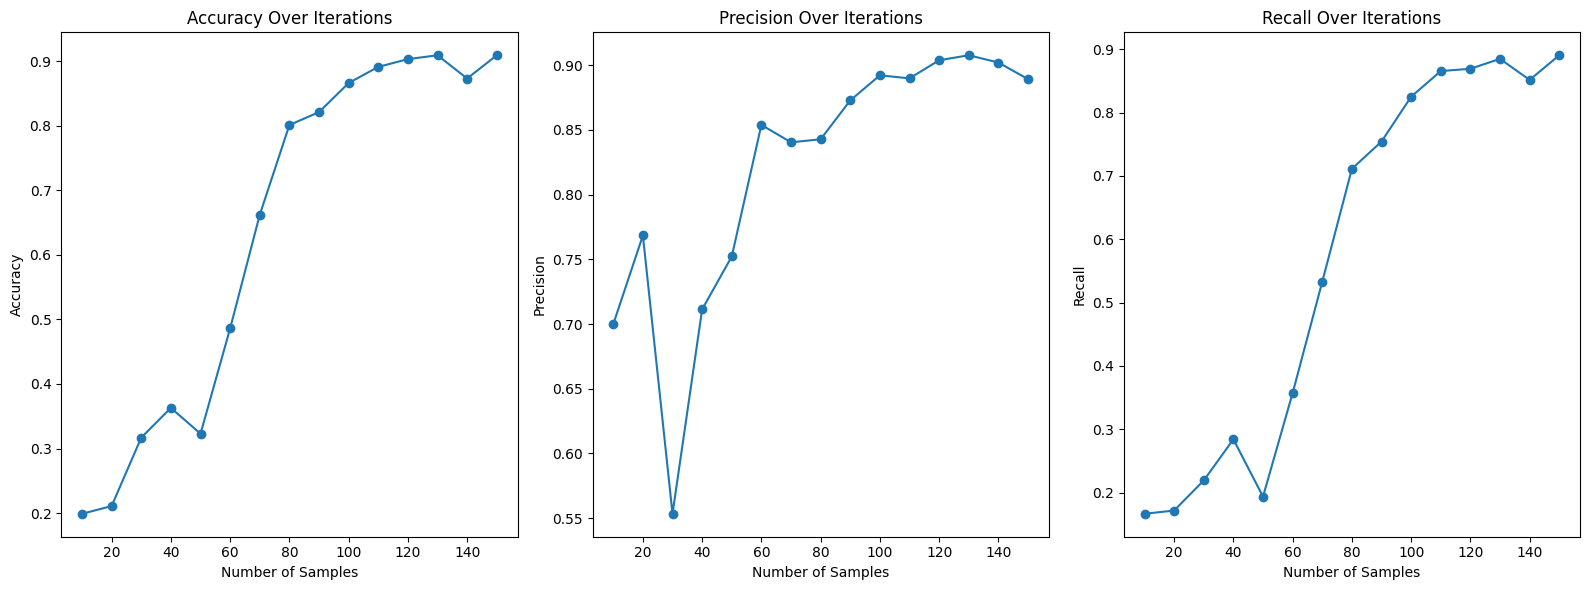

In [30]:
# Plot the metrics
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.plot(x_labels, accuracy_list, marker='o')
plt.title('Accuracy Over Iterations')
plt.xlabel('Number of Samples')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 2)
plt.plot(x_labels, precision_list, marker='o')
plt.title('Precision Over Iterations')
plt.xlabel('Number of Samples')
plt.ylabel('Precision')

plt.subplot(1, 3, 3)
plt.plot(x_labels, recall_list, marker='o')
plt.title('Recall Over Iterations')
plt.xlabel('Number of Samples')
plt.ylabel('Recall')

plt.tight_layout()
plt.show()

In [32]:
predictions = trainer.predict(test_dataloader)
predicted_labels = predictions.predictions.argmax(axis=1)
accuracy = accuracy_score(test_df['label'].to_list(),predicted_labels)
print('accuracy {}% '.format(np.round(accuracy * 100)))


  0%|          | 0/50 [00:00<?, ?it/s]

accuracy 91.0% 


In [37]:
bert_pred_df = pd.DataFrame({'Bert_Pred' : predicted_labels, 'Label' : test_df['label'].to_list() })

In [ ]:
bert_pred_df.to_csv('Craigslist_Bert_Pred.csv',index=False)

In [34]:
from sklearn.metrics import confusion_matrix


# Confusion Matrix

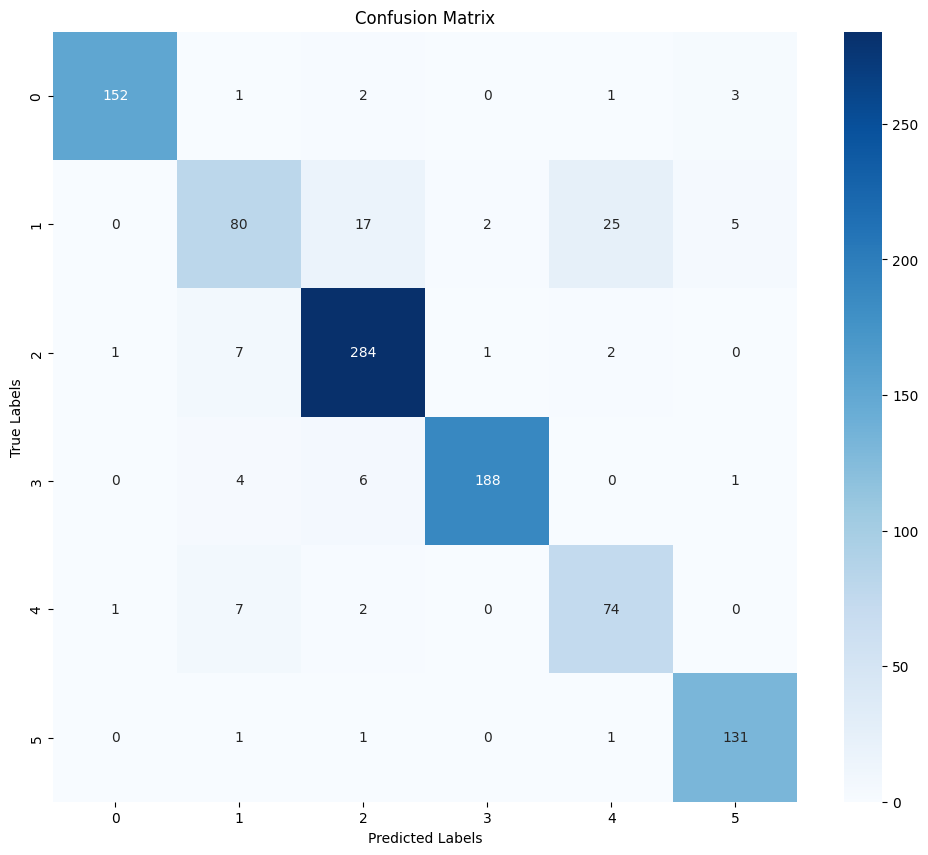

In [36]:
# Compute the confusion matrix
cm = confusion_matrix(test_df['label'].to_list(),predicted_labels)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save the confusion matrix as an image
plt.savefig('confusion_matrix.png')
plt.show()